
# Logistic Regression ( Titanic Dataset )

We will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [36]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Library for feature Scaling
from sklearn.preprocessing import RobustScaler

#Libraries for logistic Regression Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


#Library for evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [37]:
train = pd.read_csv('train.csv')

In [38]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

<Axes: >

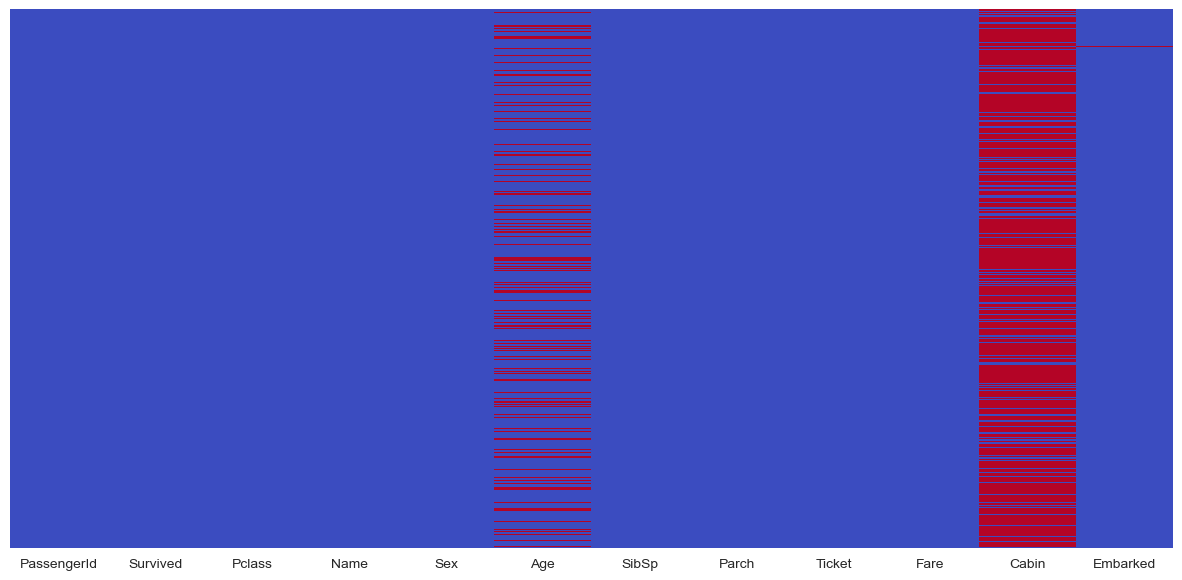

In [39]:
plt.figure(figsize=(15, 7))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

<Axes: xlabel='Survived', ylabel='count'>

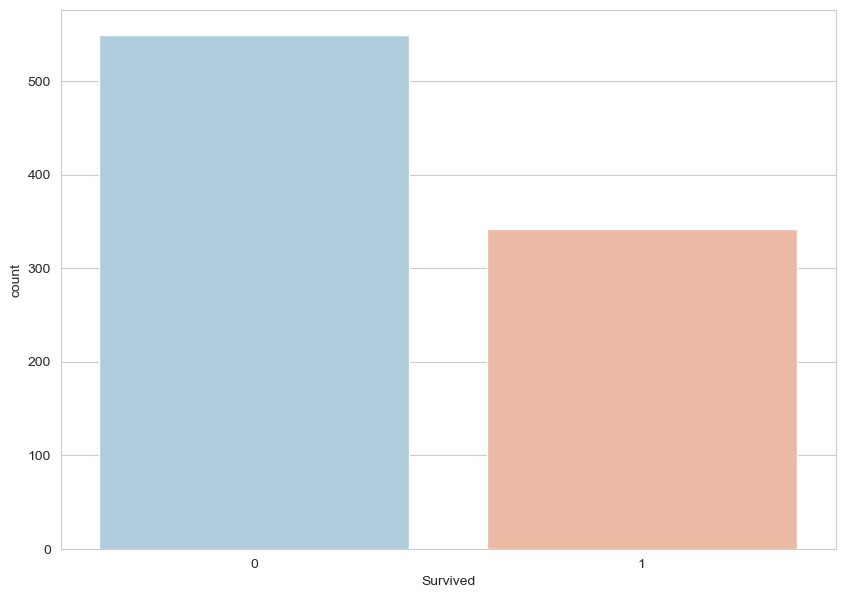

In [40]:
plt.figure(figsize=(10, 7))
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

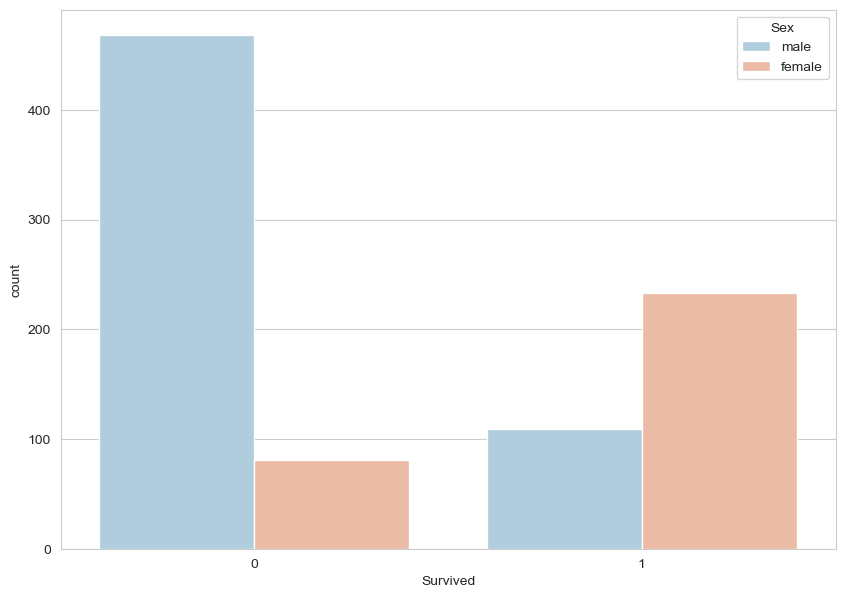

In [41]:
plt.figure(figsize=(10, 7))
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<Axes: xlabel='Age'>

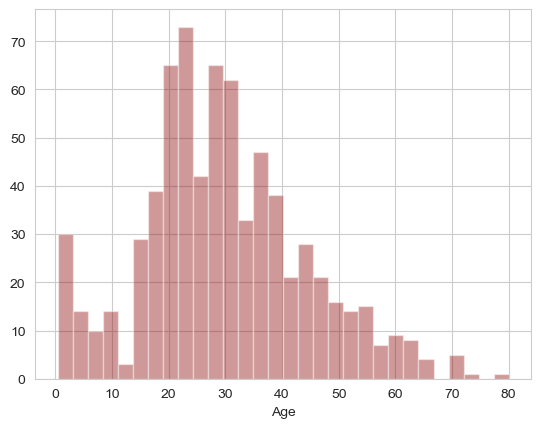

In [42]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

<Axes: >

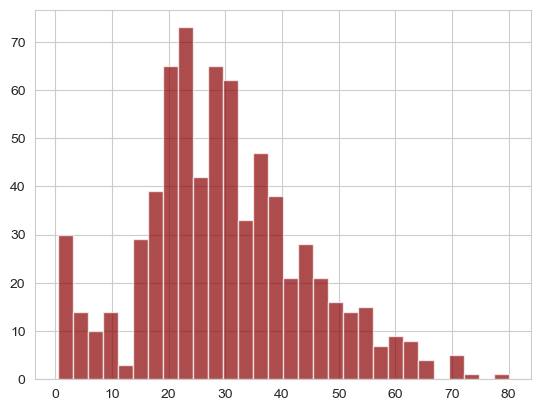

In [43]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

<Axes: xlabel='SibSp', ylabel='count'>

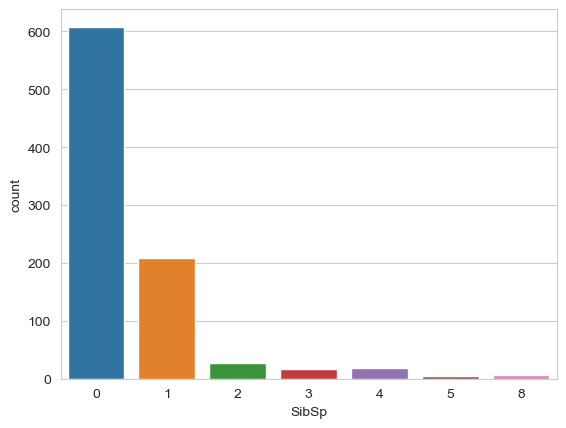

In [44]:
sns.countplot(x='SibSp',data=train)

<Axes: >

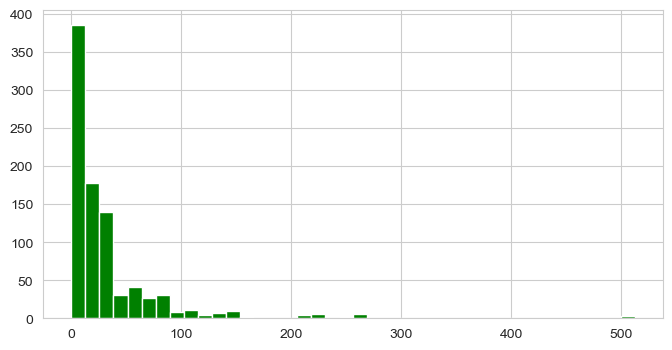

In [45]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


<Axes: xlabel='Pclass', ylabel='Age'>

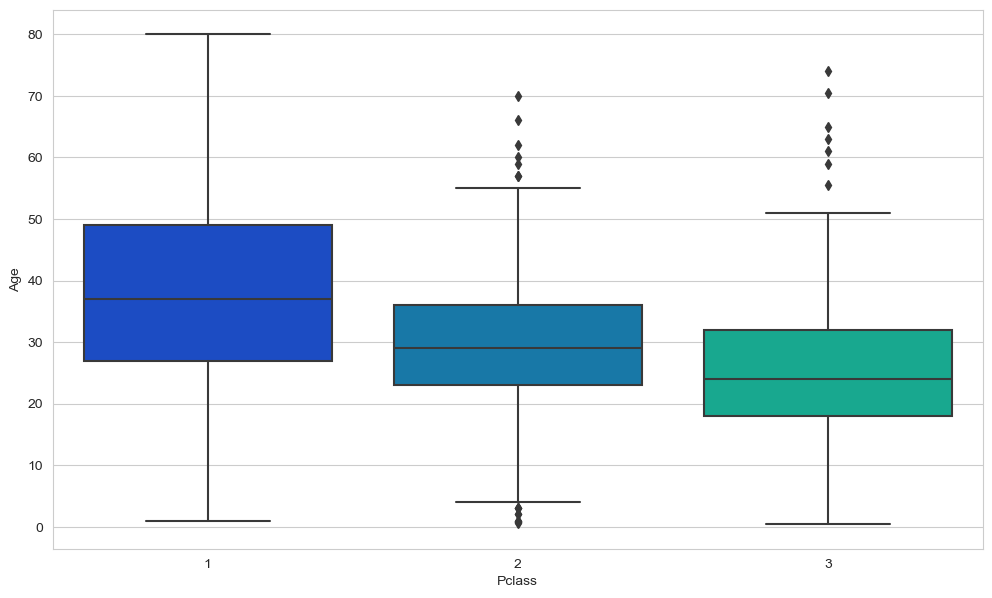

In [46]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [47]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [48]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

<Axes: >

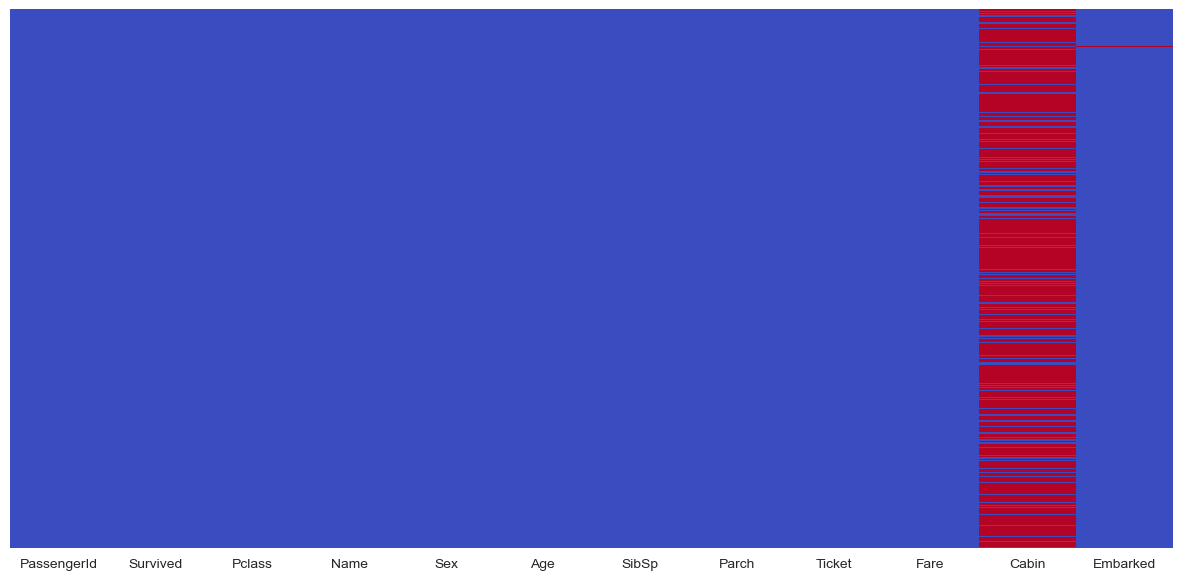

In [49]:
plt.figure(figsize=(15, 7))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [50]:
train.drop('Cabin',axis=1,inplace=True)

In [51]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [52]:
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [54]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [55]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [56]:
train = pd.concat([train,sex,embark],axis=1)

In [57]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,True,False,True
1,2,1,1,38.0,1,0,71.2833,False,False,False
2,3,1,3,26.0,0,0,7.9250,False,False,True
3,4,1,1,35.0,1,0,53.1000,False,False,True
4,5,0,3,35.0,0,0,8.0500,True,False,True


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Last step is to train our model 

Feature Scaling is scaling all your features to make sure they all take values on the same scale. It prevents one feature to dominate over the other. Feature Scaling is done after we split the dataset into the training set and test set and it is applied to the training set.

For feature scaling, we use the fit_transform() method for the training set and the transform() method for the test set.

fit_transform() : - It is applied only for training set. It contain two methods fit() and transform(). Fit() will do all the mathematical calculation and will get the mean and standard deviation of the data. So it is only done to training set, as we donot want test data values to be known by the model. As we consider test data as real data or live data. transform() method will apply the calculated values to the dataset or it transforms the data to fit the model.

transform() :- The transform() method applied to test set and test data are transformed or scaled using the model parameters that were learned on applying the fit method to the training dataset.

In [61]:
cols = X_train.columns

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train,columns=cols)
X_test = pd.DataFrame(X_test,columns=cols)

In [62]:
LogisticRegression_model = LogisticRegression(max_iter=4000)
LogisticRegression_model.fit(X_train,y_train)

LogisticRegression(max_iter=4000)

In [63]:
y_pred = LogisticRegression_model.predict(X_test)

In [64]:
y_pred

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1], dtype=int64)

Confusion matrix is used for summarizing the performance of a classification algorithm. It contains :

True Positive : Positive outcome is correctly predicted as positive.
True Negative : Negative outcome is correctly predicted as negative.
False Positive: Negative outcome is wrongly predicted as positive.
False Negative: Positive outcome is wrongly predicted as negative

In [65]:
confusion_matrix = confusion_matrix(y_test,y_pred)
confusion_matrix

array([[149,  14],
       [ 33,  71]], dtype=int64)

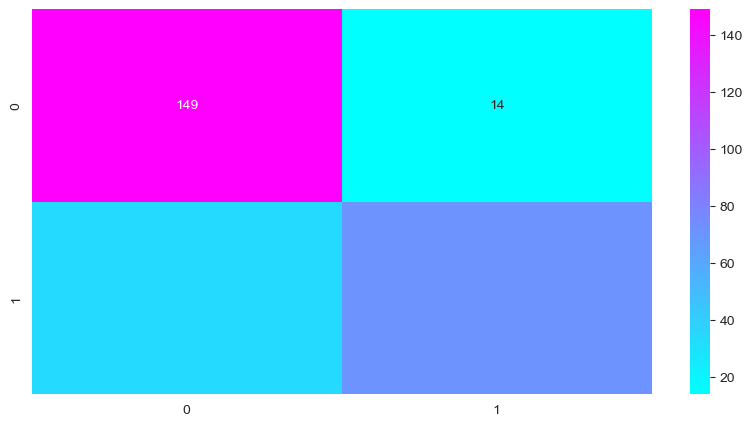

In [66]:
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='cool')
plt.show()

Accuracy : It is correctly predicted outcome to total outcomes.

Precision : It tells us if we have predicted a positive outcome, how much we are sure it will be true positive. In mathematicaly we can say, it is the proportion of true positive on all positives predictions.

Recall : It is the proportion of true positives on all actual positive elements. Recall is also known as true positive rate.

In [69]:
print('Accuracy of Logistic Regression model is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall of Logistic Regression model is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision of Logistic Regression model is : ', (metrics.precision_score(y_test, y_pred)))

Accuracy of Logistic Regression model is  :  0.8239700374531835
Recall of Logistic Regression model is    :  0.6826923076923077
Precision of Logistic Regression model is :  0.8352941176470589


##### thanks for your support :)